## 03. Computer Vision with PyTorch

What we're going to cover:
* Basic dataset
    * PyTorch FashionMNIST - https://pytorch.org/vision/stable/datasets.html
* Custom dataset 
    * (made from scratch)
* Visualizing models

Workflow:

1. Data (prepare and load)
2. Build model
3. Fitting model to data (training)
4. Making predictions and evaluating a model (inference)
    * Improving a model through experimentations (optional)
5. Saving and loading model
6. Putting it all together

In [1]:
import torch
from torch import nn

## Data

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

/home/daniel/code/pytorch/env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630841592/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Check out the data shapes
img, label = train_data[0]
img.shape, label # image is [1, 28, 28] and has int label

(torch.Size([1, 28, 28]), 9)

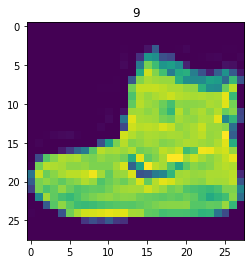

In [4]:
import matplotlib.pyplot as plt
img, label = train_data[0]
plt.imshow(img.squeeze()) # image shape is [1, 28, 28] (batch, height, width)
plt.title(label);

In [5]:
# Map labels to class names - https://github.com/zalandoresearch/fashion-mnist
# List format - https://gist.github.com/mrdbourke/e0b82c52a1b374a108a47ce21c7f4835
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

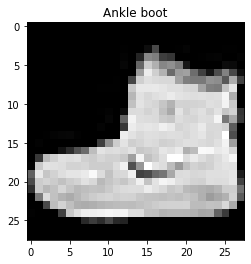

In [6]:
img, label = train_data[0]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label]);

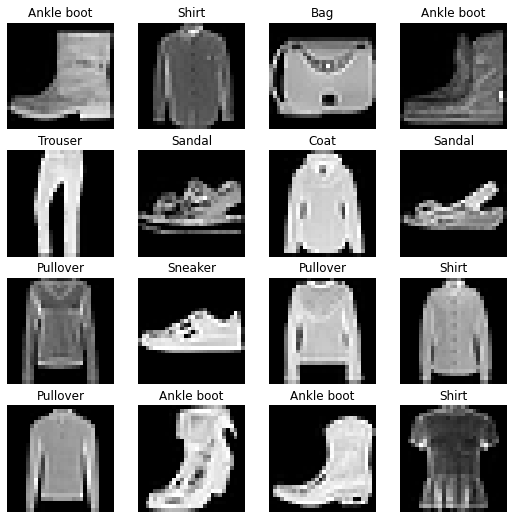

In [7]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

TK - Can these be modelled with straight lines? Let's try.

## TK - Prepare DataLoader

In [8]:
from torch.utils.data import DataLoader

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=32, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=32,
    shuffle=True
)

train_dataloader, test_dataloader, len(train_dataloader), len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x7fbf725f4e20>,
 1875,
 313)

In [9]:
# Check out dataloader
# TK - If using VSCode, be sure to check these out in the Data Viewer (go to Variables -> pick the variable you want to inspect)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


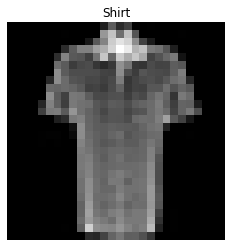

In [10]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## TK - Model 0: Build a model

Now our features and labels are prepared, let's build a model.

In [11]:
flatten_model = nn.Sequential(nn.Flatten())
x = train_features_batch[0]
output = flatten_model(x)
x.shape, output.size()


(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [12]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # TK - explain in and out features (could use TF playground for this)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=128, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [14]:
# Setup loss, optimizer and accuracy metric
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion" in some places
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [15]:
from timeit import default_timer as timer 
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

In [16]:
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Create training loop
epochs = 5
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n----------")
    for batch, (X, y) in enumerate(train_dataloader):
        # Training
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 250 == 0:
            batch_number = batch * len(X)
            print(f"Loss: {loss:.5f} | Looked at {batch_number}/{len(train_dataloader.dataset)} samples")
    
    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
            # print(test_pred)
            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y)
            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
            # print(test_acc)
    
        # Divide total loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)
        print(f"\nTesting for Epoch: {epoch}\n----------")
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_on_cpu = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))


Epoch 1
----------
Loss: 2.34053 | Looked at 0/60000 samples
Loss: 0.63385 | Looked at 8000/60000 samples
Loss: 0.49907 | Looked at 16000/60000 samples
Loss: 0.26303 | Looked at 24000/60000 samples
Loss: 0.53534 | Looked at 32000/60000 samples
Loss: 0.36563 | Looked at 40000/60000 samples
Loss: 0.68232 | Looked at 48000/60000 samples
Loss: 0.18253 | Looked at 56000/60000 samples

Testing for Epoch: 0
----------
Test loss: 0.50175 | Test accuracy: 82.47%


Epoch 2
----------
Loss: 0.57853 | Looked at 0/60000 samples
Loss: 0.36582 | Looked at 8000/60000 samples
Loss: 0.36852 | Looked at 16000/60000 samples
Loss: 0.35338 | Looked at 24000/60000 samples
Loss: 0.36890 | Looked at 32000/60000 samples
Loss: 0.34529 | Looked at 40000/60000 samples
Loss: 0.33107 | Looked at 48000/60000 samples
Loss: 0.46185 | Looked at 56000/60000 samples

Testing for Epoch: 1
----------
Test loss: 0.52408 | Test accuracy: 81.76%


Epoch 3
----------
Loss: 0.38698 | Looked at 0/60000 samples
Loss: 0.34827 | Lo

## Get Model 0 results 

In [17]:
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46738308668136597,
 'model_acc': 83.55630990415335}

In [18]:
model_0.__class__.__name__

'FashionMNISTModelV0'

## TK Setup GPU Device

We've seen how long it takes to train ma PyTorch model on 60,000 samples on CPU (note: this will dramatically depend on how many CPUs you have/the type they are/how much data you have).git/

Now let's setup some device agnostic code for our models and data to run on GPU if it's available.

See here PyTorch CUDA best practices for more: https://pytorch.org/docs/stable/notes/cuda.html#best-practices 

In [19]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## TK - Model 1: Building a better model

This model will have non-linearity.

In [20]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
    hidden_units=128,
    output_shape=10
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

## TK - Setup loss, optimizer and evaluation metrics

In [22]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

### TK - Functionizing training and test

So far we've been writing train and test loops over and over. Let's write them again but this time we'll put them in functions so they can be called again and again.

See loading data to device with `to()` - https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to 

In [23]:
def train(data_loader, model, loss_fn, optimizer):
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print what's happening
        if batch % 250 == 0: 
            sample_number = batch * len(X)
            print(f"Loss: {loss:.5f} | Looked at {sample_number}/{len(data_loader.dataset)} samples")

def test(data_loader, model, loss_fn):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"\nTesting for Epoch: {epoch}\n----------")
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [24]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs=5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer
    )
    test(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn
    )

train_time_end_on_gpu = timer()
total_train_time_on_gpu = print_train_time(start=train_time_start_on_gpu,
                                           end=train_time_end_on_gpu,
                                           device=device)

Epoch: 0
---------
Loss: 2.31576 | Looked at 0/60000 samples
Loss: 0.84441 | Looked at 8000/60000 samples
Loss: 0.72745 | Looked at 16000/60000 samples
Loss: 0.48854 | Looked at 24000/60000 samples
Loss: 0.48070 | Looked at 32000/60000 samples
Loss: 0.34006 | Looked at 40000/60000 samples
Loss: 0.60718 | Looked at 48000/60000 samples
Loss: 0.17817 | Looked at 56000/60000 samples

Testing for Epoch: 0
----------
Test loss: 0.46140 | Test accuracy: 83.58%

Epoch: 1
---------
Loss: 0.56453 | Looked at 0/60000 samples
Loss: 0.34874 | Looked at 8000/60000 samples
Loss: 0.34462 | Looked at 16000/60000 samples
Loss: 0.28178 | Looked at 24000/60000 samples
Loss: 0.34664 | Looked at 32000/60000 samples
Loss: 0.35043 | Looked at 40000/60000 samples
Loss: 0.28332 | Looked at 48000/60000 samples
Loss: 0.34145 | Looked at 56000/60000 samples

Testing for Epoch: 1
----------
Test loss: 0.44406 | Test accuracy: 84.48%

Epoch: 2
---------
Loss: 0.28065 | Looked at 0/60000 samples
Loss: 0.27538 | Looke

In [26]:
torch.manual_seed(42)

#UPTOHERE
# Make sure model eval code can run on CPU...
model_1_results = eval_model(model=model_1, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn) # will error due to `eval_model()` not using device agnostic code 
model_1_results 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat1 in method wrapper_addmm)

In [27]:
# Move values to device
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.37321436405181885,
 'model_acc': 86.46166134185303}

## TK - Model 2: Convolutional Neural Networks

In [ ]:
# UPTOHERE
# Write model v2 (conv net)
# Use same functions to train and eval

In [138]:
# class FashionMNISTModelV2(nn.Module):
#     """
#     Model architecture copying TinyVGG from: 
#     https://poloclub.github.io/cnn-explainer/
#     """
#     def __init__(self, input_shape, hidden_units, output_shape):
#         super().__init__()
#         self.layer_stack = nn.Sequential(
#             # nn.Flatten(), # flatten inputs into single vector
#             nn.Conv2d(in_channels=1, 
#                       out_channels=hidden_units, 
#                       kernel_size=3),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, 
#                       hidden_units,
#                       3),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Conv2d(hidden_units, hidden_units, 3),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#             nn.Linear(in_features=hidden_units, out_features=output_shape)
#         )
    
#     def forward(self, x):
#         return self.layer_stack(x)

# model_2 = FashionMNISTModelV2(input_shape=784, 
#     hidden_units=128, 
#     output_shape=len(class_names)).to(device)
# model_2


### Model 2 line by line
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, 
                      hidden_units,
                      3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=10)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_2 = FashionMNISTModelV2(input_shape=784, 
    hidden_units=128, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=10, bias=True)
  )
)

In [139]:
input, label = next(iter(train_dataloader))
input.shape

torch.Size([32, 1, 28, 28])

In [140]:
torch.Size([32, 128, 4, 4])

torch.Size([32, 128, 4, 4])

In [131]:
32*128*4

16384

In [141]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [142]:
# Train and test model
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs=5
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer
    )
    test(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

Epoch: 0
---------
Loss: 2.30738 | Looked at 0/60000 samples
Loss: 0.43484 | Looked at 8000/60000 samples
Loss: 0.31472 | Looked at 16000/60000 samples
Loss: 0.19138 | Looked at 24000/60000 samples
Loss: 0.33043 | Looked at 32000/60000 samples
Loss: 0.30320 | Looked at 40000/60000 samples
Loss: 0.40622 | Looked at 48000/60000 samples
Loss: 0.09584 | Looked at 56000/60000 samples

Testing for Epoch: 0
----------
Test loss: 0.28750 | Test accuracy: 89.62%

Epoch: 1
---------
Loss: 0.17540 | Looked at 0/60000 samples
Loss: 0.23340 | Looked at 8000/60000 samples
Loss: 0.12453 | Looked at 16000/60000 samples
Loss: 0.21017 | Looked at 24000/60000 samples
Loss: 0.24231 | Looked at 32000/60000 samples
Loss: 0.18512 | Looked at 40000/60000 samples
Loss: 0.15422 | Looked at 48000/60000 samples
Loss: 0.07558 | Looked at 56000/60000 samples

Testing for Epoch: 1
----------
Test loss: 0.25693 | Test accuracy: 90.46%

Epoch: 2
---------
Loss: 0.22539 | Looked at 0/60000 samples
Loss: 0.23084 | Looke

In [143]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.22770197689533234,
 'model_acc': 92.20247603833866}

In [144]:
model_0_results, model_1_results, model_2_results

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.46738308668136597,
  'model_acc': 83.55630990415335},
 {'model_name': 'FashionMNISTModelV1',
  'model_loss': 0.37321436405181885,
  'model_acc': 86.46166134185303},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.22770197689533234,
  'model_acc': 92.20247603833866})

In [145]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.467383,83.556310
1,FashionMNISTModelV1,0.373214,86.461661
2,FashionMNISTModelV2,0.227702,92.202476


<AxesSubplot:>

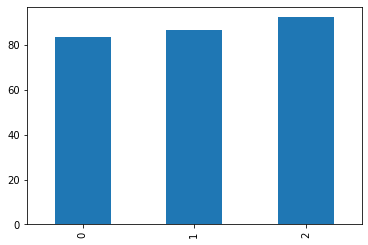

In [149]:
compare_results["model_acc"].plot(kind="bar")

## Make predictions with best model

In [151]:
def make_predictions(model, data):
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        preds = model(data)
    return preds

In [157]:
preds = make_predictions(model=model_2, data=[data for data, label in test_data][0])
preds

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


# TODO:
* ~~make testing code for training loop above~~
* ~~bring in accuracy function to measure accuracy function~~
* ~~upload accuracy function to helper_functions.py~~
* ~~"We're writing a lot of boiler plate code... but that's to practice"~~
* ~~bring in non-linearity for model 1 (it works on FashionMNIST)~~
* ~Create Conv model to really step things up - https://poloclub.github.io/cnn-explainer/ 
* ~Calculate all different model results (on same data)~
    * ~Eval model 1~
    * ~Eval model 2~
* ~Compare model results~
* Make predictions with best model
* Save and load best model

# Next notebook... (keep them short and sweet)
* then bring in another dataset (custom dataset)
* try TinyVGG on custom dataset (conv layers etc) - https://poloclub.github.io/cnn-explainer/
* compare custom dataset on and off GPU